<a href="https://colab.research.google.com/github/sakira/TensorflowInPractice/blob/master/DNNforTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def plot_series(time, series, format='-', start=0, end=None):
  #plt.figure(figsize=(10, 6))
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('time')
  plt.ylabel('value')
  plt.grid(True)
def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2* np.pi),
                  1 / np.exp(3 * season_time))

# def seasonal_pattern(season_time):
#   return np.where(season_time < 0.1,
#                   np.cos(season_time * 7 * np.pi),
#                   1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)
# adding another feature: noise

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level
time = np.arange( 4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5


# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# udpate the noise
series += noise(time, noise_level, seed=42)


split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 32
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
  print(val.numpy())


0
1
2
3
4
5
6
7
8
9


In [0]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=' ')
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [0]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=' ')
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [0]:
# create numpy array
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [0]:
# create features and labels
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

# shuffle the data
dataset = dataset.shuffle(buffer_size=10)

# batch the data
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
  #print(x.numpy(), y.numpy())
  print('x = ', x.numpy())
  print('y = ', y.numpy())

x =  [[5 6 7 8]
 [0 1 2 3]]
y =  [[9]
 [4]]
x =  [[4 5 6 7]
 [1 2 3 4]]
y =  [[8]
 [5]]
x =  [[3 4 5 6]
 [2 3 4 5]]
y =  [[7]
 [6]]


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]) )
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [0]:
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=1)






Epoch 1/100
45/45 [==============================] - 1s 11ms/step - loss: 196.6216
Epoch 2/100
45/45 [==============================] - 0s 5ms/step - loss: 146.0160
Epoch 3/100
45/45 [==============================] - 0s 6ms/step - loss: 125.6112
Epoch 4/100
45/45 [==============================] - 0s 6ms/step - loss: 110.9611
Epoch 5/100
45/45 [==============================] - 0s 6ms/step - loss: 100.8653
Epoch 6/100
45/45 [==============================] - 0s 6ms/step - loss: 94.2744
Epoch 7/100
45/45 [==============================] - 0s 6ms/step - loss: 90.6801
Epoch 8/100
45/45 [==============================] - 0s 6ms/step - loss: 83.5132
Epoch 9/100
45/45 [==============================] - 0s 6ms/step - loss: 78.9448
Epoch 10/100
45/45 [==============================] - 0s 6ms/step - loss: 76.3332
Epoch 11/100
45/45 [==============================] - 0s 6ms/step - loss: 74.4123
Epoch 12/100
45/45 [==============================] - 0s 6ms/step - loss: 71.3159
Epoch 13/100
45/45 

In [0]:
print('Layer weights {}'.format(l0.get_weights()))

Layer weights [array([[-1.0716383e-02],
       [ 9.4058551e-03],
       [ 1.1208416e-03],
       [ 4.6720249e-03],
       [-2.3155553e-02],
       [-1.6113741e-02],
       [ 2.4629638e-02],
       [-9.6115196e-04],
       [-1.3396009e-03],
       [ 1.7904198e-02],
       [ 1.3574142e-02],
       [ 4.1286228e-03],
       [-2.7887385e-02],
       [-1.8646734e-02],
       [ 3.2975886e-02],
       [-2.9102124e-02],
       [ 4.4779640e-02],
       [-1.6414186e-02],
       [-2.4736743e-02],
       [-3.9512459e-03],
       [ 1.9350655e-02],
       [ 2.8001302e-04],
       [ 1.8267879e-02],
       [-2.4204955e-03],
       [-9.4235959e-03],
       [ 7.7768005e-03],
       [ 2.2990864e-02],
       [ 3.4860209e-02],
       [ 6.4471588e-02],
       [ 1.8233848e-01],
       [ 2.6458526e-01],
       [ 4.2110455e-01]], dtype=float32), array([0.0161432], dtype=float32)]


In [0]:
print(series[:window_size])
model.predict(series[:window_size][np.newaxis])

[52.48357  49.35275  53.314735 57.711823 48.934444 48.931244 57.982895
 53.897125 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178
 40.919415 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938
 47.335835 48.6033   40.93184  45.11266  48.15732  41.6051   48.985233
 43.839634 45.109936 43.275043 55.249832]


array([[49.397552]], dtype=float32)

In [0]:
# prediction
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.900009

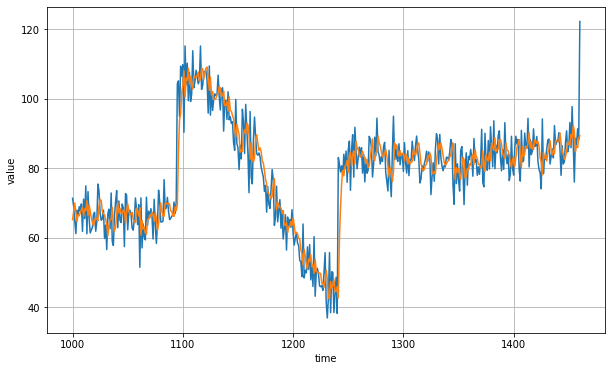

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(1)
])

In [0]:
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

In [34]:
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=1, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 14ms/step - loss: 1812.2445
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 1558.3188
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 1265.8043
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 986.5985
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 767.1707
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 566.8235
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 404.9585
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 305.1459
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 245.9004
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 219.3469
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 206.0623
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 198.1528
Epoch 13/

[1e-08, 0.001, 0, 300]

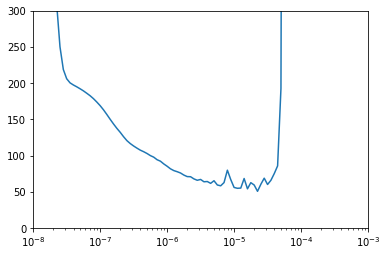

In [35]:
# loss per epoch

lrs = 1e-8 * (10** (np.arange(100) / 20) )
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

In [0]:
# # loss per epoch

# lrs = 1e-8 * (10** (np.arange(100) / 20) )
# plt.semilogx(lrs, history.history['loss'])


In [36]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)


Epoch 1/500
31/31 [==============================] - 0s 13ms/step - loss: 342.3003
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 80.5593
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 64.3843
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 61.1640
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 65.0706
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 55.8872
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 55.4781
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 59.0240
Epoch 9/500
31/31 [==============================] - 0s 6ms/step - loss: 53.6124
Epoch 10/500
31/31 [==============================] - 0s 6ms/step - loss: 52.2151
Epoch 11/500
31/31 [==============================] - 0s 6ms/step - loss: 51.0811
Epoch 12/500
31/31 [==============================] - 0s 6ms/step - loss: 58.2582
Epoch 13/500
31/31 [===

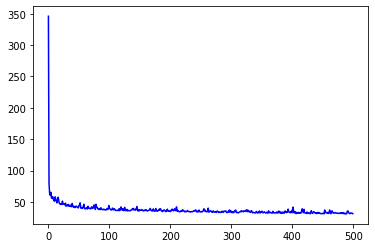

In [37]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[51.261488177112696, 58.249447679028066, 53.77424950353878, 51.72364048908666, 48.51975467327944, 55.09506216147511, 57.57089441043814, 51.93425302800444, 47.51603065569376, 46.973500847570676, 46.1108096211227, 47.66651272331316, 45.93649004120188, 51.45919780927835, 47.25836485243335, 46.44451802047258, 46.7133582832887, 45.40708567039254, 48.15769396123198, 43.31271193199551, 44.39147459993657, 45.42337678732331, 43.77953189181299, 46.101531691403736, 43.281510429775594, 44.12486399227811, 42.89328529908485, 45.30174297844012, 42.493112418577844, 47.76872957760526, 43.56555494328135, 41.908116790928794, 43.2629395239132, 41.392753593208866, 41.1639018343896, 43.164923866507934, 43.522920667510675, 41.92107380739192, 41.365583824865595, 40.49605723902122, 44.41774430029171, 45.443882263812824, 48.76889277586003, 40.35752354061481, 41.31048813652747, 39.99998022649706, 39.83406180155646, 42.6621517613991, 46.45528460630437, 40.8062016280656, 39.01417631562223, 39.20928315624748, 40.54

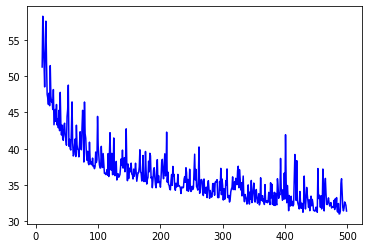

In [38]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

tf.Tensor(5.134096, shape=(), dtype=float32)


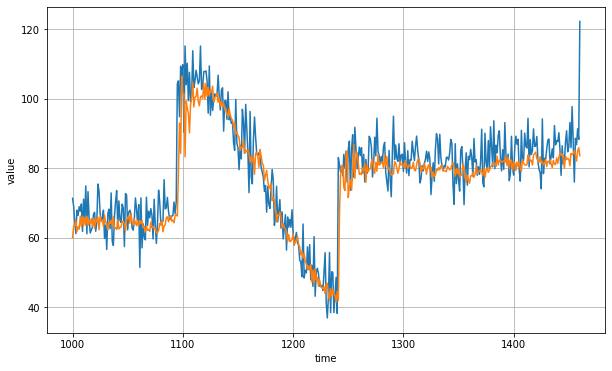

In [39]:
# prediction
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_absolute_error(x_valid, results))